# 整体建模

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# 创建数据
data = {
    "Bandwidth_MB_s": [41.746, 62.982, 65.596, 101.968, 138.671, 159.773, 177.197, 190.415, 193.555, 194.056, 194.097,
                       193.776, 193.419, 193.679, 194.425, 194.462, 36.732, 55.592, 80.364, 100.85, 116.875, 133.242,
                       160.23, 178.519, 189.055, 193.55, 193.752, 193.717, 193.417, 193.686, 194.365, 194.416, 33.096,
                       48.456, 72.221, 97.357, 113.762, 125.266, 134.315, 164.453, 178.744, 187.352, 192.915, 193.512,
                       192.669, 193.47, 194.342, 194.218],
    "Cards": [64] * 16 + [128] * 16 + [256] * 16,
    "Data_MB": [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304,
                8388608, 16777216] * 3
}

# 转换为DataFrame
df = pd.DataFrame(data)

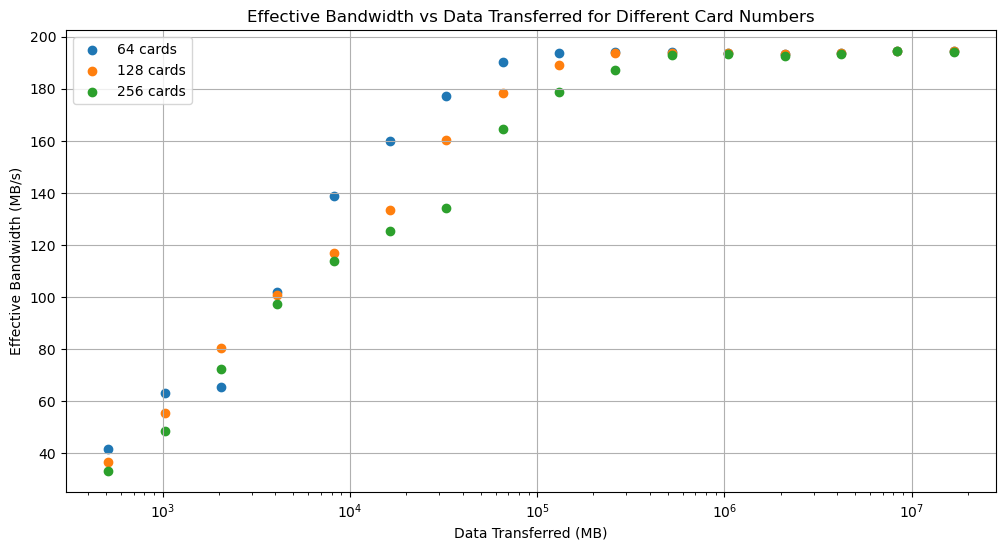

,Bandwidth_MB_s,Cards,Data_MB
0,41.746,64,512
1,62.982,64,1024
2,65.596,64,2048
3,101.968,64,4096
4,138.671,64,8192


In [2]:
# 可视化数据
plt.figure(figsize=(12, 6))
for card in df['Cards'].unique():
    subset = df[df['Cards'] == card]
    plt.scatter(subset['Data_MB'], subset['Bandwidth_MB_s'], label=f'{card} cards')

plt.xlabel('Data Transferred (MB)')
plt.ylabel('Effective Bandwidth (MB/s)')
plt.title('Effective Bandwidth vs Data Transferred for Different Card Numbers')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

# 显示前几行数据以验证
df.head()


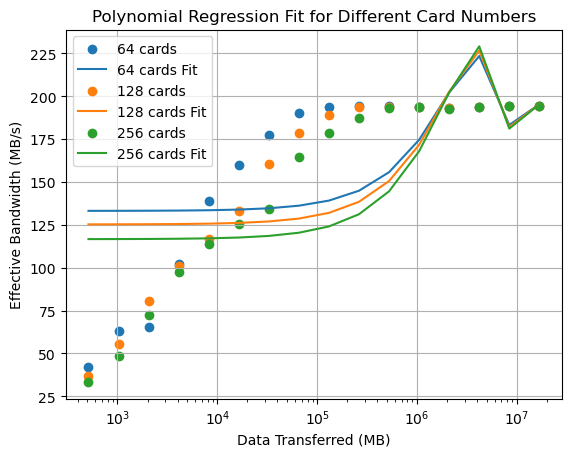

{64: 0.29521420726901804, 128: 0.37275935247217706, 256: 0.4423389359860739}

In [3]:

# 准备多项式回归模型
degree = 3  # 多项式的度数
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

# 用于存储拟合结果和评分
models = {}
scores = {}

# 分别对每个卡数的数据进行拟合
for card in df['Cards'].unique():
    subset = df[df['Cards'] == card]

    # 准备数据
    X = subset['Data_MB'].values.reshape(-1, 1)
    y = subset['Bandwidth_MB_s'].values
    X_poly = poly_features.fit_transform(X)

    # 拟合模型
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)

    # 评估模型
    score = r2_score(y, y_pred)

    # 存储模型和评分
    models[card] = model
    scores[card] = score

    # 可视化拟合结果
    plt.scatter(X, y, label=f'{card} cards')
    plt.plot(X, y_pred, label=f'{card} cards Fit')

# 绘制图表
plt.xlabel('Data Transferred (MB)')
plt.ylabel('Effective Bandwidth (MB/s)')
plt.title('Polynomial Regression Fit for Different Card Numbers')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# 输出评分
scores



# 分段建模

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# 重新创建数据
data = {
    "Bandwidth_MB_s": [41.746, 62.982, 65.596, 101.968, 138.671, 159.773, 177.197, 190.415, 193.555, 194.056, 194.097,
                       193.776, 193.419, 193.679, 194.425, 194.462, 36.732, 55.592, 80.364, 100.85, 116.875, 133.242,
                       160.23, 178.519, 189.055, 193.55, 193.752, 193.717, 193.417, 193.686, 194.365, 194.416, 33.096,
                       48.456, 72.221, 97.357, 113.762, 125.266, 134.315, 164.453, 178.744, 187.352, 192.915, 193.512,
                       192.669, 193.47, 194.342, 194.218],
    "Cards": [64] * 16 + [128] * 16 + [256] * 16,
    "Data_MB": [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304,
                8388608, 16777216] * 3
}

# 转换为DataFrame
df = pd.DataFrame(data)

# 定义分段
segments = {
    'small': (512, 32768),  # 512KB - 32MB
    'medium': (65536, 524288),  # 64MB - 512MB
    'large': (1048576, 16777216)  # 1GB - 16GB
}

# 用于存储拟合结果和评分
segment_scores = {seg: {} for seg in segments}

# 对每个分段和卡数的数据进行拟合
for seg, (low, high) in segments.items():
    for card in df['Cards'].unique():
        subset = df[(df['Cards'] == card) & (df['Data_MB'] >= low) & (df['Data_MB'] <= high)]

        # 如果该段中没有足够的数据点，则跳过
        if len(subset) < 2:
            continue

        # 准备数据
        X = subset['Data_MB'].values.reshape(-1, 1)
        y = subset['Bandwidth_MB_s'].values
        poly_features = PolynomialFeatures(degree=3, include_bias=False)
        X_poly = poly_features.fit_transform(X)

        # 拟合模型
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)

        # 评估模型
        score = r2_score(y, y_pred)
        segment_scores[seg][card] = score

segment_scores



{'small': {64: 0.9926098278054787,
  128: 0.9742885934257572,
  256: 0.9785981614428321},
 'medium': {64: 0.9999999999999999, 128: 0.9999999999999999, 256: 1.0},
 'large': {64: 0.8762202065751417,
  128: 0.90516654511101,
  256: 0.7579091281319981}}

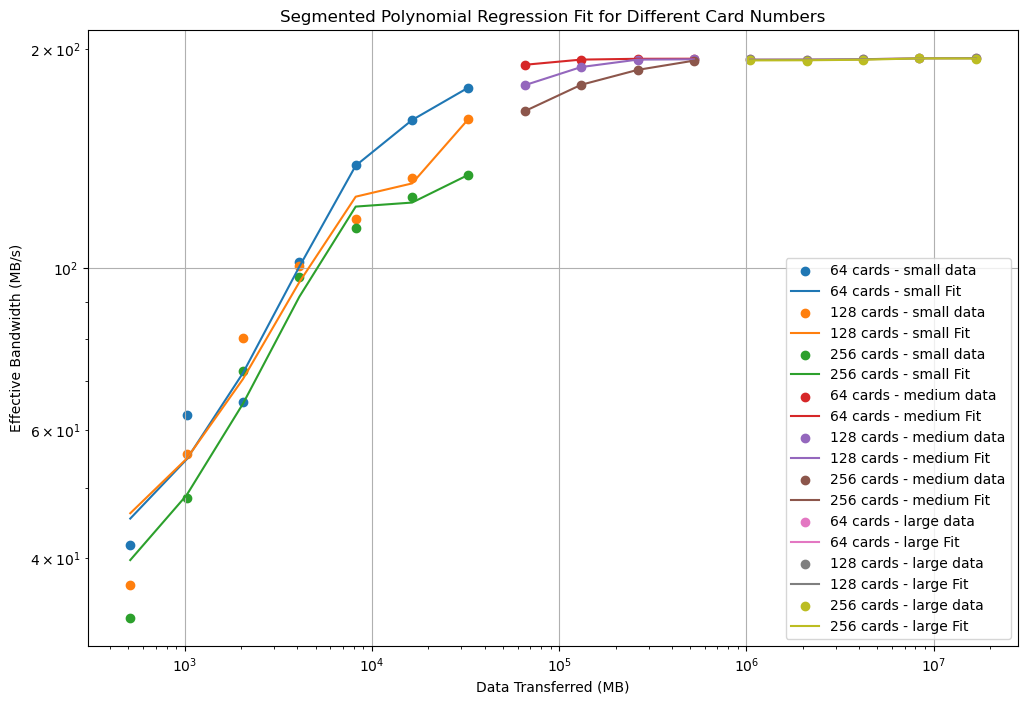

In [5]:
import matplotlib.pyplot as plt

# 可视化每个分段的拟合结果
plt.figure(figsize=(12, 8))

# 遍历每个分段和卡数，绘制拟合曲线
for seg, (low, high) in segments.items():
    for card in df['Cards'].unique():
        subset = df[(df['Cards'] == card) & (df['Data_MB'] >= low) & (df['Data_MB'] <= high)]

        # 如果该段中没有足够的数据点，则跳过
        if len(subset) < 2:
            continue

        # 准备数据
        X = subset['Data_MB'].values.reshape(-1, 1)
        y = subset['Bandwidth_MB_s'].values
        poly_features = PolynomialFeatures(degree=3, include_bias=False)
        X_poly = poly_features.fit_transform(X)

        # 从之前的模型中获取预测值
        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)

        # 绘制散点图和拟合曲线
        plt.scatter(X, y, label=f'{card} cards - {seg} data')
        plt.plot(X, y_pred, label=f'{card} cards - {seg} Fit')

# 设置图表
plt.xlabel('Data Transferred (MB)')
plt.ylabel('Effective Bandwidth (MB/s)')
plt.title('Segmented Polynomial Regression Fit for Different Card Numbers')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# 重新定义分段和拟合模型
segments = {
    'small': (512, 32768),
    'medium': (65536, 524288),
    'large': (1048576, 16777216)
}

# 存储模型
models = {seg: {card: None for card in df['Cards'].unique()} for seg in segments}

# 拟合每个分段的模型
for seg, (low, high) in segments.items():
    for card in df['Cards'].unique():
        subset = df[(df['Cards'] == card) & (df['Data_MB'] >= low) & (df['Data_MB'] <= high)]

        # 跳过数据点不足的情况
        if len(subset) < 2:
            continue

        X = subset['Data_MB'].values.reshape(-1, 1)
        y = subset['Bandwidth_MB_s'].values
        poly_features = PolynomialFeatures(degree=3, include_bias=False)
        X_poly = poly_features.fit_transform(X)

        model = LinearRegression().fit(X_poly, y)
        models[seg][card] = model

# 预测35 MB数据量下的有效带宽
data_volume = 35 * 1024  # 将35 MB转换为KB
predictions = {}

# 使用中等数据量段的模型进行预测
for card, model in models['medium'].items():
    if model:
        X_pred = poly_features.fit_transform([[data_volume]])
        predictions[card] = model.predict(X_pred)[0]

predictions



{64: 188.05814877500305, 128: 171.1472231815731, 256: 154.86182354376223}